In [1]:
import os
import time

import numpy as np
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
transform = transforms.Compose([
                    transforms.ToTensor(), 
            ])

testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128
                                                    , shuffle=True, num_workers=4)

test_loader = torch.utils.data.DataLoader(testset,batch_size=128
                                                     , shuffle=True, num_workers=4)


100%|██████████| 169001437/169001437 [00:12<00:00, 13277567.03it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
all_train_labels = []
all_test_labels = []
all_val_labels = []

for images, labels in train_loader:  
    all_train_labels.append(labels)
all_train_labels = torch.cat(all_train_labels)
    
for images, labels in test_loader:  
    all_test_labels.append(labels)
all_test_labels = torch.cat(all_test_labels)



print('Training labels:', torch.unique(all_train_labels))
print('Training label distribution:', torch.bincount(all_train_labels))

print('\nTest labels:', torch.unique(all_test_labels))
print('Test label distribution:', torch.bincount(all_test_labels))




Training labels: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
        90, 91, 92, 93, 94, 95, 96, 97, 98, 99])
Training label distribution: tensor([500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
        500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
        500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
        500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
        500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
        500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
        500, 500, 500, 500, 500, 500,

In [4]:
import re
from collections import OrderedDict
from functools import partial
from typing import Any, List, Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from torch import Tensor


class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate) :
        super(_DenseLayer,self).__init__()
        self.bottleneck = nn.Sequential(
            OrderedDict(
                [
                    ("norm1", nn.BatchNorm2d(num_input_features)),
                    ("ELU1", nn.ELU(inplace=True)),
                    ("conv1", nn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)),
                ]
            )
        )
        self.denselayers = nn.Sequential(
            OrderedDict(
                [
                    ("norm2", nn.BatchNorm2d(bn_size * growth_rate)),
                    ("ELU2", nn.ELU(inplace=True)),
                    ("conv2", nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)),
                ]
            )
        )
        self.drop_rate=drop_rate


    def forward(self, input):
        concated_features = torch.cat(input, 1)
        bottleneck_output = self.bottleneck(concated_features)
        new_features = self.denselayers(bottleneck_output)
        new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return new_features


class _DenseBlock(nn.ModuleDict):

    def __init__(self,num_layers,num_input_features,bn_size,growth_rate,drop_rate):
        super(_DenseBlock,self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate
            )
            self.add_module("denselayer%d" % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition,self).__init__()
        self.norm = nn.BatchNorm2d(num_input_features)
        self.ELU = nn.ELU(inplace=True)
        self.conv = nn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)


class DenseNetIOC(nn.Module):

    def __init__(self,growth_rate= 32,block_config=[6, 12, 24, 16],num_init_features= 64,bn_size= 4,drop_rate = 0,num_classes = 1000):

        super(DenseNetIOC,self).__init__()

        self.features = nn.Sequential(
            OrderedDict(
                [
                    ("conv0", nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
                    ("norm0", nn.BatchNorm2d(num_init_features)),
                    ("ELU0", nn.ELU(inplace=True)),
                    ("pool0", nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
                ]
            )
        )

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate
            )
            self.features.add_module("denseblock%d" % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module("transition%d" % (i + 1), trans)
                num_features = num_features // 2

        self.features.add_module("norm5", nn.BatchNorm2d(num_features))

        self.classifier = nn.Linear(num_features, num_classes)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.elu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out




In [5]:
def train_model_ioc(optimizer,scheduler,trainloader,testloader,criterion,model,epochs,epsilon):
    
    def train(optimizer,trainloader,criterion):
        model.train()
        train_loss=0
        y_true=[]
        y_pred=[]
        for images, labels in trainloader:
            model.zero_grad() 
            data = images.to(device)
            target = labels.to(device)
            output = model(data)
            loss = criterion(output,target)
            indices=torch.max(output,1)[1] 
            train_loss+=loss.item()
            y_true+=list(target.detach().cpu().numpy())
            y_pred+=list(indices.detach().cpu().numpy())
            loss.backward()
            optimizer.step()
            with torch.no_grad():
              i=0
              for params in model.parameters():
                  if i != 0:
                    newparams=params.detach().clone()
                    params.copy_(torch.where(newparams < 0, torch.exp(newparams - epsilon), newparams))
                  i=i+1
        
        return train_loss/len(trainloader),accuracy_score(y_true,y_pred)
    def test(testloader,criterion):
        model.eval()
        y_true=[]
        y_pred=[]        
        val_loss = 0
        with torch.no_grad():
          for images, labels in testloader:
              data = images.to(device)
              target = labels.to(device)
              output = model(data)
              indices=torch.max(output,1)[1]
              y_true+=list(target.detach().cpu().numpy())
              y_pred+=list(indices.detach().cpu().numpy())
              val_loss += criterion(output, target).item()
        return val_loss/len(testloader),accuracy_score(y_true,y_pred)

        
    train_loss=[]

    test_loss=[]
    train_acc=[]

    test_acc=[]
    for epoch in tqdm(range(1, epochs + 1)):
        
        tr_loss,tr_acc=train(optimizer=optimizer,trainloader=trainloader,criterion=criterion)
        ts_loss,ts_acc=test(testloader,criterion=criterion)
        scheduler.step()
        train_loss.append(tr_loss)
        test_loss.append(ts_loss)
        train_acc.append(tr_acc)
        test_acc.append(ts_acc)
        print("\n",tr_acc)
        print(ts_acc)
    return (train_loss,test_loss),(train_acc,test_acc)
    
def plot(Loss,EPOCH):
  x = list(range(1,EPOCH+1))
  fig, ax = plt.subplots(figsize=(7,7))
  ax.plot(x, Loss[0], '-', label='train', color='green')
  ax.plot(x, Loss[1], '-', label='test', color='red')

  ax.legend()
  plt.show()

  2%|▏         | 1/50 [00:50<41:31, 50.85s/it]


 0.01914
0.0201


  4%|▍         | 2/50 [01:41<40:26, 50.55s/it]


 0.02372
0.0221


  6%|▌         | 3/50 [02:31<39:32, 50.48s/it]


 0.02628
0.0269


  8%|▊         | 4/50 [03:22<38:53, 50.74s/it]


 0.02786
0.0305


 10%|█         | 5/50 [04:14<38:13, 50.96s/it]


 0.04104
0.0507


 12%|█▏        | 6/50 [05:04<37:13, 50.76s/it]


 0.05102
0.0568


 14%|█▍        | 7/50 [05:55<36:21, 50.72s/it]


 0.06388
0.0646


 16%|█▌        | 8/50 [06:46<35:34, 50.82s/it]


 0.07686
0.0898


 18%|█▊        | 9/50 [07:35<34:29, 50.48s/it]


 0.0947
0.0958


 20%|██        | 10/50 [08:25<33:31, 50.30s/it]


 0.10828
0.1136


 22%|██▏       | 11/50 [09:15<32:36, 50.18s/it]


 0.11846
0.1276


 24%|██▍       | 12/50 [10:05<31:47, 50.20s/it]


 0.12982
0.082


 26%|██▌       | 13/50 [10:56<30:56, 50.17s/it]


 0.13966
0.1103


 28%|██▊       | 14/50 [11:46<30:05, 50.15s/it]


 0.1467
0.1355


 30%|███       | 15/50 [12:35<29:11, 50.04s/it]


 0.15178
0.1377


 32%|███▏      | 16/50 [13:25<28:17, 49.93s/it]


 0.16914
0.1761


 34%|███▍      | 17/50 [14:14<27:21, 49.75s/it]


 0.17364
0.1812


 36%|███▌      | 18/50 [15:04<26:28, 49.65s/it]


 0.17362
0.1789


 38%|███▊      | 19/50 [15:53<25:38, 49.63s/it]


 0.17454
0.1729


 40%|████      | 20/50 [16:44<24:55, 49.84s/it]


 0.17544
0.1754


 42%|████▏     | 21/50 [17:34<24:09, 49.98s/it]


 0.1755
0.1811


 44%|████▍     | 22/50 [18:24<23:17, 49.90s/it]


 0.17596
0.1773


 46%|████▌     | 23/50 [19:13<22:20, 49.66s/it]


 0.17668
0.1809


 48%|████▊     | 24/50 [20:02<21:30, 49.65s/it]


 0.1773
0.1808


 50%|█████     | 25/50 [20:53<20:45, 49.84s/it]


 0.17938
0.1802


 52%|█████▏    | 26/50 [21:45<20:14, 50.60s/it]


 0.17954
0.1829


 54%|█████▍    | 27/50 [22:36<19:28, 50.79s/it]


 0.17916
0.184


 56%|█████▌    | 28/50 [23:27<18:38, 50.85s/it]


 0.18176
0.1796


 58%|█████▊    | 29/50 [24:18<17:44, 50.68s/it]


 0.18286
0.1844


 60%|██████    | 30/50 [25:08<16:54, 50.72s/it]


 0.18318
0.1826


 62%|██████▏   | 31/50 [25:58<15:59, 50.49s/it]


 0.18522
0.1911


 64%|██████▍   | 32/50 [26:48<15:04, 50.23s/it]


 0.1846
0.1883


 66%|██████▌   | 33/50 [27:40<14:21, 50.67s/it]


 0.18586
0.1882


 68%|██████▊   | 34/50 [28:31<13:31, 50.71s/it]


 0.18544
0.1879


 70%|███████   | 35/50 [29:20<12:35, 50.38s/it]


 0.18574
0.1888


 72%|███████▏  | 36/50 [30:11<11:46, 50.47s/it]


 0.1838
0.1871


 74%|███████▍  | 37/50 [31:01<10:56, 50.47s/it]


 0.185
0.1897


 76%|███████▌  | 38/50 [31:51<10:04, 50.37s/it]


 0.18622
0.1884


 78%|███████▊  | 39/50 [32:41<09:11, 50.13s/it]


 0.18604
0.1886


 80%|████████  | 40/50 [33:30<08:19, 49.94s/it]


 0.18634
0.1905


 82%|████████▏ | 41/50 [34:23<07:35, 50.63s/it]


 0.18454
0.1885


 84%|████████▍ | 42/50 [35:16<06:51, 51.39s/it]


 0.18512
0.1879


 86%|████████▌ | 43/50 [36:07<05:59, 51.37s/it]


 0.18682
0.1897


 88%|████████▊ | 44/50 [36:58<05:07, 51.17s/it]


 0.18512
0.1902


 90%|█████████ | 45/50 [37:49<04:15, 51.03s/it]


 0.18598
0.1897


 92%|█████████▏| 46/50 [38:40<03:24, 51.05s/it]


 0.18598
0.1894


 94%|█████████▍| 47/50 [39:31<02:33, 51.00s/it]


 0.18552
0.1903


 96%|█████████▌| 48/50 [40:20<01:41, 50.60s/it]


 0.18594
0.1899


 98%|█████████▊| 49/50 [41:11<00:50, 50.52s/it]


 0.18628
0.1912


100%|██████████| 50/50 [42:00<00:00, 50.42s/it]


 0.18834
0.1913


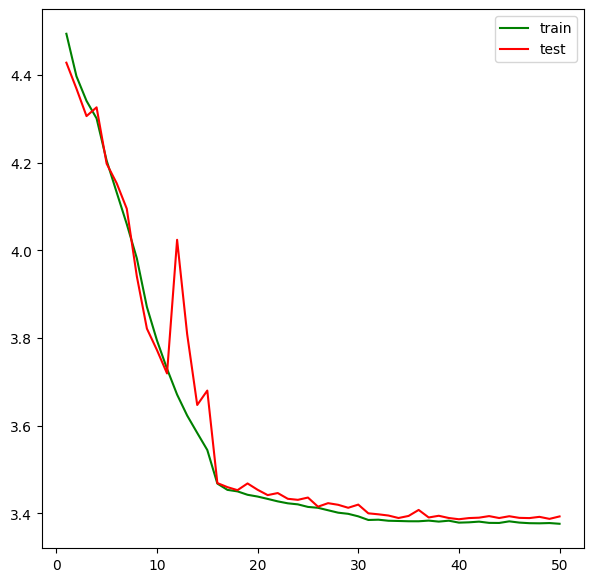

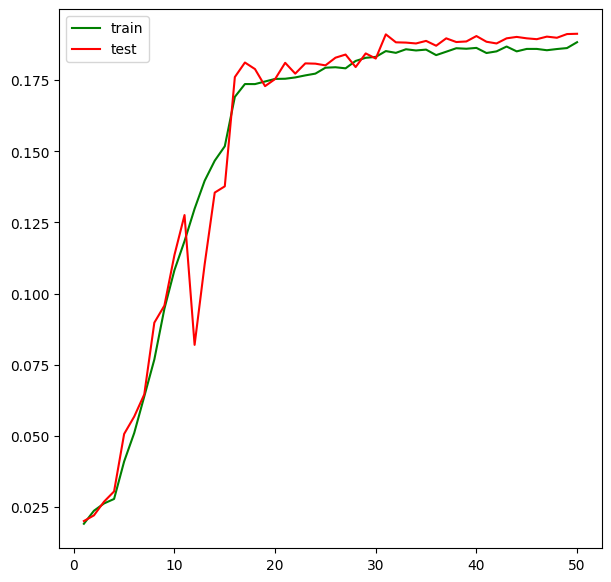

In [8]:
dense_net=DenseNetIOC(block_config=[6,12,24,16],growth_rate=12,num_classes=len(torch.unique(all_train_labels)))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCH=50
epsilon=5
criterion =  nn.CrossEntropyLoss()
dense_net = dense_net.to(device)
criterion = criterion.to(device)
optimizer = optim.Adam(dense_net.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
Loss,accuracy=train_model_ioc(optimizer,scheduler,train_loader,test_loader,criterion,dense_net,EPOCH,epsilon)
plot(Loss,EPOCH)
plot(accuracy,EPOCH)

In [9]:
torch.save(dense_net,"dense_net_121_IOC.pt")